# Overview

1. import packages and assign bias attribute
2. look at the distribution of one protected attribute
3. run through all the attributes and asses the largest imbalance
4. fix imbalance and check for bias
    - 4.1 Example of augmentation
    - 4.2 Which pictures to augment
    - 4.3 Augmenting the right pictures
5. Checking the number of channels
6. Training

## 1. import packages and assign bias attribute

In [1]:
import pickle
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
plt.style.use(['seaborn-whitegrid'])

In [2]:
train = pd.read_csv("Data/train.csv")

In [3]:
train_len = len(train)

In [4]:
attr = list(train.columns[1:41])

In [19]:
protected_attr = "Double_Chin"
target = "Chubby"

## 2. Look at the distribution of one protected attribute

In [20]:
train = train[[target,protected_attr]]

In [21]:
#This is only done for the groupby command in the below cell
train["fill"] = 9

In [22]:
dist = train.groupby([protected_attr,target]).count()

In [23]:
dist = dist.fill

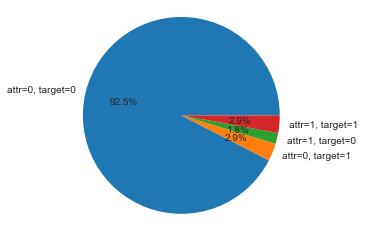

In [24]:
labels = 'attr=0, target=0', 'attr=0, target=1', 'attr=1, target=0', 'attr=1, target=1'
sizes = list(dist)
#colors = ['blue', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels,autopct='%1.1f%%')

plt.axis('equal')
plt.show()

In [25]:
dist

Double_Chin  Chubby
0            0         150486
             1           4713
1            0           2895
             1           4676
Name: fill, dtype: int64

In [12]:
k = list(dist)

In [13]:
k

[0.45872089451373105,
 0.392191435768262,
 0.061583829944092894,
 0.08750383977391411]

In [14]:
d = []

d.append([k[0]/k[1], k[2]/k[3]])

In [15]:
d

[[1.169635164559738, 0.7037843151021554]]

Lav en dataframe som opsummerer alle de forskellige uligheder i data for at assesse hvilke af de to der er størst ulighed på. Her kan man bruge en ratio ligesom på posteren

## 3. Run trough all attributes and asses the largest imbalance

In [16]:
train = pd.read_csv("Data/train.csv")
train_len = len(train)

In [17]:
attr = list(train.columns[1:41])
target = "Smiling"
attr.remove('Smiling')

In [18]:
diff = []
for i in attr:
    protected_attr = i
    train_ = train[[target,protected_attr]]
    train_["fill"] = 9
    dist = train_.groupby([protected_attr,target]).count()
    dist = dist.fill/train_len
    k = list(dist)
    diff.append([i, k[0]/k[1], k[2]/k[3]])

/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
diff = pd.DataFrame(diff)

In [20]:
diff.columns = ['Protected_attr', 'ratio attr 0', 'ratio attr 1']

In [21]:
diff.sort_values(['ratio attr 0', 'ratio attr 1'], ascending=[False, False])

,Protected_attr,ratio attr 0,ratio attr 1
19,High_Cheekbones,4.895290,0.169674
21,Mouth_Slightly_Open,3.506684,0.321803
24,No_Beard,1.810684,0.982841
35,Wearing_Lipstick,1.531834,0.737955
2,Attractive,1.477375,0.812570
18,Heavy_Makeup,1.436306,0.693147
25,Oval_Face,1.413508,0.550134
33,Wearing_Earrings,1.276655,0.524120
29,Rosy_Cheeks,1.218442,0.113403
3,Bags_Under_Eyes,1.214488,0.697440


In [22]:
diff.sort_values(['ratio attr 1'], ascending=[False]).head()

,Protected_attr,ratio attr 0,ratio attr 1
26,Pale_Skin,1.051888,2.232580
22,Mustache,1.055695,2.116847
30,Sideburns,1.044507,2.108998
34,Wearing_Hat,1.053061,1.962049
16,Goatee,1.044928,1.921707


When looking at the two heads, we that
- 3/10 is not a part of our poster (wearing hat, lipstick, no_beard) 
- 4/10 has detected bias from our definition (gotee, pale_skin, mouth_slightly_open, high_cheekbones)
- 3/10 has no detected bias from our definition (mustache, sideburns, attractive) 

## 4. Fix imbalance

We would like to balance the unbalanced training set. Looking at the attribute with the largest imbalance, `high_cheekbones` (were our metric also detected a bias), we see that the `ratio_attr_0` is 4.8 and `ratio_attr_1` is 0.17. 

The ratio formula is essentially
$$
ratio\_attr\_0 = \frac{attr = 0, target = 0}{attr = 0, target = 1}
$$
and 
$$
ratio\_attr\_1 = \frac{attr = 1, target = 0}{attr = 1, target = 1}
$$

This mans that 
- out of all the people NOT having high cheeckbones, 4.8 times as many were not smiling than smiling 
- out of all the people HAVING high cheeckbones, many more were smiling than not smiling

and hence this particular training data is very unbbalanced..

Inspired by the following article, https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6, we have three absic approaches (more complex ones exist of course): 

1. Undersampling- Randomly delete the class which has sufficient observations so that the comparative ratio of two classes is significant in our data.Although this approach is really simple to follow but there is a high possibility that the data that we are deleting may contain important information about the predictive class.
2. Oversampling-For the unbalanced class randomly increase the number of observations which are just copies of existing samples.This ideally gives us sufficient number of samples to play with.The oversampling may lead to overfitting to the training data
3. Synthetic sampling(SMOTE)-The technique asks to synthetically manufacture observations of unbalanced classes which are similar to the existing using nearest neighbors classification.The problem is what to do when the number of observations of is an extremely rare class .For example-we may have only one picture of a rare species which we want to identify using image classification algorithm

I am using option 2 below

In [23]:
import os
from PIL import Image
from PIL import ImageFilter

#### 4.1 Example of augmentation

In [24]:
im=Image.open('/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3/000001.jpg')

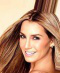

In [25]:
im

In [26]:
im=im.convert("RGB")
r,g,b=im.split()
r=r.convert("RGB")
g=g.convert("RGB")
b=b.convert("RGB")
#im_blur=im.filter(ImageFilter.GaussianBlur)
im_unsharp=im.filter(ImageFilter.UnsharpMask)

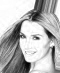

In [27]:
r

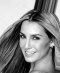

In [28]:
g

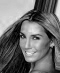

In [29]:
b

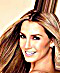

In [30]:
im_unsharp

In [31]:
#We choose only to use the im_unsharp and the b picture together with the normal pictur
# which means, that we are augmenting 3 pictures every time we upsample 1 time
pictures_upsampling = 3

#### 4.2 Which pictures to augment

As we in this particular example, want to upsample the number of smiling people with high cheekbones and the number of non-smiling people with high cheekbones. 

In [32]:
#assessing the number of pictures that are different
train = pd.read_csv("Data/train.csv")
train_len = len(train)
attr = list(train.columns[1:41])
protected_attr = "Blond_Hair"
target = "Smiling"

In [33]:
train.head()

,im_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [34]:
#Defining train as only the target and the protected attribute
train = train[[target,protected_attr]]
#This is only done for the groupby command in the below cell
train["fill"] = 9
#Groupby and counting the number of occurances
dist = train.groupby([protected_attr,target]).count()

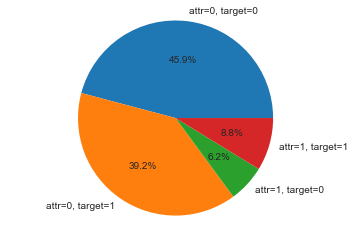

In [35]:
labels = 'attr=0, target=0', 'attr=0, target=1', 'attr=1, target=0', 'attr=1, target=1'
sizes = list(dist.fill)
#colors = ['blue', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels,autopct='%1.1f%%')

plt.axis('equal')
plt.show()

In [36]:
dist

fill
Blond_Hair Smiling       
0          0        74666
           1        63837
1          0        10024
           1        14243

In [37]:
#This is only training data
sum(dist.fill)

162770

As seen from the table above, we could potentially also downsample, however, we would loose a lot of information. We need to upsample around 60,000 pictures of smiling people without high cheeckbone (smiling_not_highcheekbones = `s_n_hc`), and around 50,000 pictures of non-smiling people with high cheekbones (nonsmiling_highcheekbones = `ns_hc`). 

In [38]:
#Reading all the attributes for every single image and which partition it belongs to:
pp = pd.read_csv('Data/list_attr_celeba.txt', sep= " ")
part = pd.read_csv('Data/list_eval_partition.txt', sep= " ",header = None)

In [39]:
pp.head()

,im_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Unnamed: 41
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,NaN
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,NaN
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,NaN
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,NaN
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,NaN


In [40]:
#naming columns in the partition dataset
part.columns = ['im_id','partition']

Filtering the training examples

In [41]:
pp = pp.merge(part, how = 'left', on = 'im_id')

In [42]:
pp.shape

(202599, 43)

In [43]:
pp = pp[pp.partition == 0]

In [44]:
#Now we have filtered the test data out of the sample
pp.shape

(162770, 43)

In [45]:
#AND it is equal to the amount of datapoints in the groupby table
sum(dist.fill)

162770

# Outdated ----

Creating a list of the two different characteristics that we want to obtain

In [60]:
s_n_hc = pp[(pp[target] == 1) & (pp[protected_attr] == -1)].im_id

In [61]:
#We see that this number is the same as in the dist table above
len(s_n_hc)

63837

In [62]:
ns_hc = pp[(pp[target] == -1) & (pp[protected_attr] == 1)].im_id

In [63]:
#We see that this number is the same as in the dist table above
len(ns_hc)

10024

# Outdated done ----

In [70]:
dist

fill
Blond_Hair Smiling       
0          0        74666
           1        63837
1          0        10024
           1        14243

In [71]:
a0_t1 = pp[(pp[target] == 1) & (pp[protected_attr] == -1)].im_id

In [72]:
#We see that this number is the same as in the dist table above
len(a0_t1)

63837

In [73]:
a1_t0 = pp[(pp[target] == -1) & (pp[protected_attr] == 1)].im_id

In [74]:
#We see that this number is the same as in the dist table above
len(a1_t0)

10024

In [75]:
a1_t1 = pp[(pp[target] == 1) & (pp[protected_attr] == 1)].im_id

In [76]:
#We see that this number is the same as in the dist table above
len(a1_t1)

14243

In [83]:
upsample = max(dist.fill)

#### 4.3 Augmenting the right pictures

In [66]:
dist.fill

Blond_Hair  Smiling
0           0          74666
            1          63837
1           0          10024
            1          14243
Name: fill, dtype: int64

In [92]:
a0_t1_count = upsample-len(a0_t1)
print(a0_t1_count)

10829


In [93]:
a1_t0_count = upsample - len(a1_t0)
print(a1_t0_count)

64642


In [94]:
a1_t1_count = upsample - len(a1_t1)
print(a1_t1_count)

60423


In [116]:
upsampling = [list(a0_t1) , list(a1_t0), list(a1_t1)]
a0_t1_up = int(np.round(a0_t1_count/pictures_upsampling))
a1_t0_up = int(np.round(a1_t0_count/pictures_upsampling))
a1_t1_up = int(np.round(a1_t1_count/pictures_upsampling))
range_ = [a0_t1_up , a1_t0_up, a1_t1_up]
#For test:
#range_ = [5, 5, 5]

In [117]:
range_

[3610, 21547, 20141]

# Outdated ----

In [77]:
#Ensuring that we are subtracting the right numbers. It is always the differece between
# the two attributes we want:
if dist.fill[0][0]>dist.fill[0][1]:
    a0_t1_count = dist.fill[0][0]-dist.fill[0][1]
else:
    a0_t1_count = dist.fill[0][1]-dist.fill[0][0]

In [78]:
#Ensuring that we are subtracting the right numbers. It is always the differece between
# the two attributes we want:
if dist.fill[1][1]>dist.fill[1][0]:
    a1_t0_count = dist.fill[1][1]-dist.fill[1][0]
else: 
    a1_t0_count = dist.fill[1][0]-dist.fill[1][1]

In [79]:
print('We need to get',s_n_hc_count,'number of smiling non HC-people, and',ns_hc_count,'numbber of non-similing HC-people. \n')
print('As we can make', pictures_upsampling, 'different augmentations of every image, that means we need to random sample',\
     s_n_hc_count/pictures_upsampling,'smiling non HC-people, and',ns_hc_count/pictures_upsampling\
      ,'non-similing HC-people.')

We need to get 10829 number of smiling non HC-people, and 4219 numbber of non-similing HC-people. 

As we can make 3 different augmentations of every image, that means we need to random sample 3609.6666666666665 smiling non HC-people, and 1406.3333333333333 non-similing HC-people.


In [ ]:
upsampling = [list(s_n_hc) , list(ns_hc)]
s_n_hc_up = int(np.round(s_n_hc_count/pictures_upsampling))
ns_hc_up = int(np.round(ns_hc_count/pictures_upsampling))
range_ = [s_n_hc_up , ns_hc_up]

In [ ]:
#Check that this is equal to the print statement above:
s_n_hc_up

In [ ]:
#Check that this is equal to the print statement above:
ns_hc_up

# Outdated done ----

In [118]:
img_root = '/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3/'
saveto_root = '/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3_Blond_Hair/'
train = pd.read_csv("Data/train.csv")

In [119]:
from tqdm import tqdm

In [120]:
traindf = copy.deepcopy(train)

In [121]:
#Writing pictures 
for i in range(3):
    augment = upsampling[i]
    rang = range_[i]
    for k in tqdm(range(rang)):
        image = random.randrange(len(augment))
        image = augment[image]
        im=Image.open(img_root+image)
        im_=im.convert("RGB")
        r,g,b=im_.split()
        r=r.convert("RGB")
        g=g.convert("RGB")
        b=b.convert("RGB")
        im_unsharp=im_.filter(ImageFilter.UnsharpMask)

        #r.save(saveto_root+'r_'+str(k)+"_"+image)
        #g.save(saveto_root+'g_'+str(k)+"_"+image)
        
        #Saving image, b, and unsharp:
        im.save(saveto_root+'im_'+str(k)+"_"+image)#Added
        b.save(saveto_root+'b_'+str(k)+"_"+image)
        im_unsharp.save(saveto_root+'un_'+str(k)+"_"+image)
        
        
        traindf = traindf.append([train[train.im_id==image]]*pictures_upsampling\
                                 ,ignore_index=True)
        
        traindf.iloc[-1,0] = 'un_'+str(k)+"_"+image
        traindf.iloc[-2,0] = 'b_'+str(k)+"_"+image
        traindf.iloc[-3,0] = 'im_'+str(k)+"_"+image
        
traindf.to_csv('Data/train_augmented_'+protected_attr+'.csv')

100%|██████████| 20141/20141 [1:17:25<00:00,  4.53it/s]


In [122]:
len(traindf)

298664

In [123]:
len(traindf)-len(train)

135894

In [124]:
#Have to be the same as the following number:
sum(range_*3)

135894

In [107]:
traindf.tail()

,im_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
162849,b_26_126132.jpg,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
162850,un_26_126132.jpg,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
162851,im_27_128010.jpg,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,1,0,0,0
162852,b_27_128010.jpg,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,1,0,0,0
162853,un_27_128010.jpg,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,1,0,0,0


In [ ]:
len(train)

In [ ]:
traindf.tail()

In [ ]:
traindf = pd.read_csv("Data/train_augmented_mouth.csv")

In [ ]:
train = traindf[[target,protected_attr]]
#This is only done for the groupby command in the below cell
train["fill"] = 9
dist = train.groupby([protected_attr,target]).count()

In [ ]:
dist

In [ ]:
#len(train)

In [ ]:
traindf.tail(30)

In [ ]:
#Lets check out many pictures is in the folder:
import os
files = os.listdir(saveto_root)
print(len(files))

In [ ]:
#when we would like to have 
sum(range_)*3

In [ ]:
#added also has this many pictures - thises all needs to be added to the dataframe, traindf
len(added)

In [ ]:
#Saving pictures as pickle
with open("Data/pictures_augmented.txt", "wb") as fp:   #Pickling
    pickle.dump(added, fp)

In [ ]:
#Reading pickle with list of photos that ahs been augmented
with open("Data/pictures_augmented.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

Since the method defined for the training of the models needs a data-frame where it reads from the `im_id` columns in order to find the picture, we need to add all these pictures with their attributes to the dataframe. 

In [ ]:
for i, img in enumerate(added):
    #print(img)
    if i%10000==0:
        print(i)

In [ ]:
for img in added:
    traindf = traindf.append(traindf[traindf.im_id==img])
    traindf = traindf.append(traindf[traindf.im_id==img])
    traindf = traindf.append(traindf[traindf.im_id==img])
    traindf = traindf.append(traindf[traindf.im_id==img])
    
    traindf.iloc[-1,0] = str(k)+'r_'+img
    traindf.iloc[-2,0] = str(k)+'g_'+img
    traindf.iloc[-3,0] = str(k)+'b_'+img
    traindf.iloc[-4,0] = str(k)+'un_'+img

In [ ]:
len(traindf)-len(train)

In [ ]:
traindf.tail(20)

We have sampled the images so that we have the correct amount of each class! 

## 5. Checking the number of channels

In [ ]:
im=Image.open('/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3_aug/0r_057136.jpg')

In [ ]:
#channels
len(im.mode)

In [ ]:
im.getbands()

## 6. Training

Happens on AWS!